In [1]:
# import packages
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from ibm_quantum_widgets import draw_circuit
from qiskit_ionq import IonQProvider
import matplotlib
import pylatexenc

import qiskit
from qiskit import Aer
import numpy as np


simulator = Aer.get_backend('qasm_simulator')

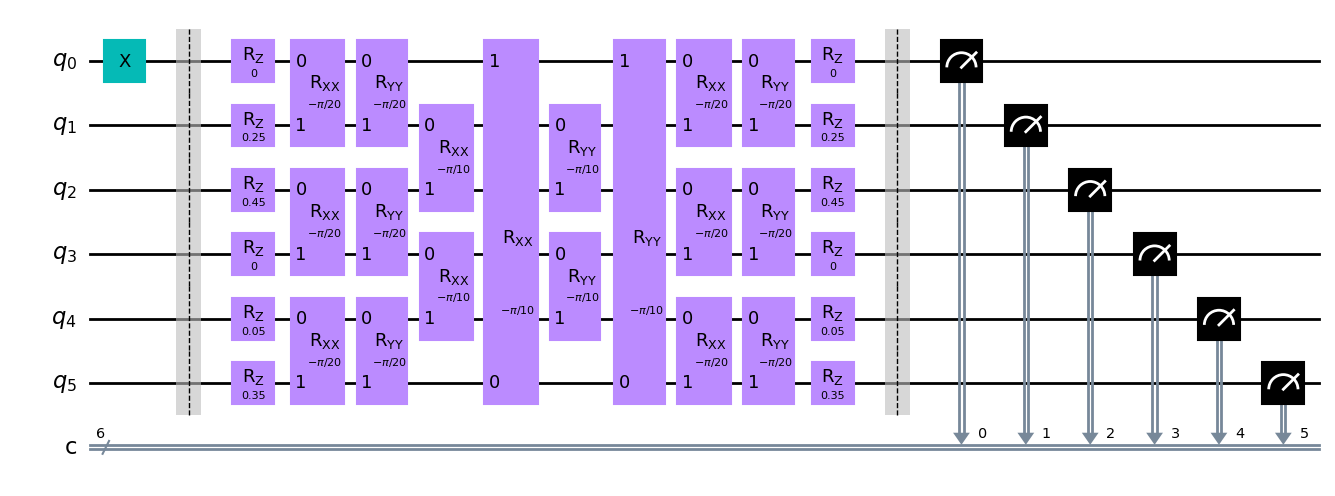

In [27]:
# JSON data
json_data = {
    "computer": "ionq",  # quantum computer to use
    "qbit_count": 6,     # number of qubits to use
    "places": [          # list of places to visit and their probabilities
        {"place": "Gym", "probability": 0.2},
        {"place": "Opera", "probability": 0.5},
        {"place": "Rooftop bar", "probability": 0.9},
        {"place": "Street fair", "probability": 0.0},
        {"place": "Pool", "probability": 0.1},
        {"place": "Museum", "probability": 0.7},
    ]
}

# Retrieve probabilities
probabilities = []
for place in json_data['places']:
    probabilities.append(place['probability'])

# Quantum circuit variables
start = 0
probabilities[start] = 0
steps = 1
J_val = np.pi / 10

# Define Qiskit parameters
L = len(probabilities)
J = Parameter('J')
K_i = []
for i in range(L):
    K_i.append(Parameter('K_'+str(i)))

# Define unitary
qc_U = QuantumCircuit(L)
qc_U.barrier()
for i in range(L):
    qc_U.rz(K_i[i]/2, i)
for i in range(L):
    if i % 2 == 0:
        qc_U.rxx(-J / 2, i % L, (i+1) % L)
        qc_U.ryy(-J / 2, i % L, (i+1) % L)
for i in range(L):
    if i % 2 != 0:
        qc_U.rxx(-J, i % L, (i+1) % L)
        qc_U.ryy(-J, i % L, (i+1) % L)
for i in range(L):
    if i % 2 == 0:
        qc_U.rxx(-J/2, i % L, (i+1) % L)
        qc_U.ryy(-J/2, i % L, (i+1) % L)
for i in range(L):
    qc_U.rz(K_i[i]/2, i)

# Compose main quantum circuit by duplicating the unitary circuit every step
qc_main = QuantumCircuit(L)
qc_main.x(start)
for step in range(steps):
    qc_main = qc_main.compose(qc_U, qubits=range(L))

# Add measurement circuit
qc_measure = QuantumCircuit(L, L)
qc_measure.measure_all(add_bits=False)
qc_end = qc_main.compose(qc_measure, range(L))

# Bind Qiskit parameters
qc_end = qc_end.bind_parameters({J: J_val})
for ind in range(L):
    qc_end = qc_end.bind_parameters({K_i[ind]: probabilities[ind]})

# Draw quantum circuit
# qc_end.draw()
# qc_U.draw(output='mpl')
# qc_main.draw(output='mpl')
# qc_measure.draw(output='mpl')
# qc_end.draw(output='mpl', filename='./circuit.png', vertical_compression=True)

# Transpile and run
# trans_circ = transpile(qc_end, backend)
# job = backend.run(trans_circ)
# results = job.result().get_counts()
# results


In [8]:
def random_walk(start, J_val, K_vals, steps):
    L = len(K_vals)
    #Define Parameters
    J = Parameter('J')
    K_i = []
    for ind in range(L):
        K_i.append(Parameter('K_'+str(ind)))
    #Define Unitary
    qc_U = QuantumCircuit(L)
    for i in range(L):
        qc_U.rz(K_i[i]/2, i)
    for i in range(L):
        if i % 2 == 0:
            qc_U.rxx(-J/2, i%L, (i+1)%L)
            qc_U.ryy(-J/2, i%L, (i+1)%L)
    for i in range(L):
        if i % 2 != 0:
            qc_U.rxx(-J, i%L, (i+1)%L)
            qc_U.ryy(-J, i%L, (i+1)%L)
    for i in range(L):
        if i % 2 == 0:
            qc_U.rxx(-J/2, i%L, (i+1)%L)
            qc_U.ryy(-J/2, i%L, (i+1)%L)
    for i in range(L):
        qc_U.rz(K_i[i]/2, i)
        #qc_U.p(K_i[i], i)
    #Compose Main Circuit with set number of Unitary steps:
    qc_main = QuantumCircuit(L)
    qc_main.x(start)
    for step in range(steps):
        qc_main = qc_main.compose(qc_U, qubits=range(L))
    #Add Measurement Circuit
    qc_meas = QuantumCircuit(L,L)
    qc_meas.measure_all(add_bits=False)
    qc_end = qc_main.compose(qc_meas, range(L))
    #Bind Parameters
    qc_end = qc_end.bind_parameters({J:J_val})
    for ind in range(L):
        qc_end = qc_end.bind_parameters({K_i[ind]:K_vals[ind]})
    #Transpile and Run
    trans_circ = transpile(qc_end, backend)
    job = backend.run(trans_circ)
    #Return the counts for the jobs
    return job.result().get_counts()

In [4]:
def random_walk(start, J_val, J_val_2, K_vals, steps):
    L = len(K_vals)

    #Define Parameters
    J = Parameter('J')
    J2 = Parameter('J2')
    K_i = []
    for ind in range(L):
        K_i.append(Parameter('K_'+str(ind)))

    #Define Unitary
    qc_U = QuantumCircuit(L)
    for i in range(L):
        qc_U.rz(K_i[i]/2, i)

    #even - nearest neighbors
    for i in range(L):
        if i % 2 == 0:
            qc_U.rxx(-J/2, i%L, (i+1)%L)
            qc_U.ryy(-J/2, i%L, (i+1)%L)
    #odd - nearest neighbors
    for i in range(L):
        if i % 2 != 0:
            qc_U.rxx(-J/2, i%L, (i+1)%L)
            qc_U.ryy(-J/2, i%L, (i+1)%L)

    #evens - 2nd nearest neighbors
    for i in range(L):
        if i % 2 == 0:
            qc_U.rxx(-J2/2, i%L, (i+2)%L)
            qc_U.ryy(-J2/2, i%L, (i+2)%L)
    #odds - 2nd nearest neighbors
    for i in range(L):
        if i % 2 != 0:
            qc_U.rxx(-J2, i%L, (i+2)%L)
            qc_U.ryy(-J2, i%L, (i+2)%L)   
    #evens - 2nd nearest neighbors     
    for i in range(L):
        if i % 2 == 0:
            qc_U.rxx(-J2/2, i%L, (i+2)%L)
            qc_U.ryy(-J2/2, i%L, (i+2)%L)

    #odd - nearest neighbors
    for i in range(L):
        if i % 2 != 0:
            qc_U.rxx(-J/2, i%L, (i+1)%L)
            qc_U.ryy(-J/2, i%L, (i+1)%L)
    #even nearest neighbors
    for i in range(L):
        if i % 2 == 0:
            qc_U.rxx(-J/2, i%L, (i+1)%L)
            qc_U.ryy(-J/2, i%L, (i+1)%L)
    for i in range(L):
        qc_U.rz(K_i[i]/2, i)
        #qc_U.p(K_i[i], i)

    #Compose Main Circuit with set number of Unitary steps:
    qc_main = QuantumCircuit(L)
    qc_main.x(start)
    for step in range(steps):
        qc_main = qc_main.compose(qc_U, qubits=range(L))

    #Add Measurement Circuit
    qc_meas = QuantumCircuit(L,L)
    qc_meas.measure_all(add_bits=False)
    qc_end = qc_main.compose(qc_meas, range(L))

    #Bind Parameters
    qc_end = qc_end.bind_parameters({J:J_val})
    qc_end = qc_end.bind_parameters({J2:J_val_2})
    for ind in range(L):
        qc_end = qc_end.bind_parameters({K_i[ind]:K_vals[ind]})

    #Transpile and Run
    trans_circ = transpile(qc_end, backend)
    job = backend.run(trans_circ)

    #Return the counts for the jobs
    return job.result().get_counts()

In [7]:
start = 0
K_vals = 0 * np.ones(12)
K_vals[0] = 0
steps = 5
J_val = np.pi/10


results = random_walk(start, J_val, J_val, K_vals, steps)
results

{'000000000001': 87,
 '000000000010': 14,
 '000000000100': 135,
 '000000001000': 73,
 '000000010000': 28,
 '000000100000': 59,
 '000001000000': 221,
 '000010000000': 103,
 '000100000000': 11,
 '001000000000': 160,
 '010000000000': 132,
 '100000000000': 1}

In [8]:
K_vals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])